In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import umap
import os
import warnings
warnings.filterwarnings('ignore')

In [41]:
plt.style.use('ggplot')
sns.set_palette('Set2')

In [42]:
df = pd.read_csv('clinical.tsv', sep='\t')

In [43]:
df = df.set_index('attrib_name').T.reset_index()
df = df.rename(columns={'index': 'sample_id'})

In [44]:
print("Столбцы после транспонирования:", df.columns.tolist())

Столбцы после транспонирования: ['sample_id', 'years_to_birth', 'Tumor_purity', 'pathology_T_stage', 'pathology_N_stage', 'histological_type', 'number_of_lymph_nodes', 'gender', 'radiation_therapy', 'residual_tumor', 'race', 'ethnicity', 'overall_survival', 'status', 'overallsurvival']


In [45]:
feature_cols = [col for col in df.columns if col != 'sample_id']

In [46]:
for col in feature_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')


In [47]:
print("\n=== Пропущенные значения до обработки ===")
missing_data = df[feature_cols].isna().sum()
print(missing_data[missing_data > 0])


=== Пропущенные значения до обработки ===
attrib_name
years_to_birth            11
Tumor_purity               2
pathology_T_stage        499
pathology_N_stage        499
histological_type        499
number_of_lymph_nodes     91
gender                   499
radiation_therapy        499
residual_tumor           499
race                     499
ethnicity                499
overall_survival           3
status                     3
overallsurvival          499
dtype: int64


In [48]:
# Удаление столбцов, где все значения NaN
valid_cols = [col for col in feature_cols if not df[col].isna().all()]
if not valid_cols:
    raise ValueError("Все столбцы содержат только NaN. Проверьте данные в clinical.tsv.")

df = df[['sample_id'] + valid_cols]
feature_cols = valid_cols

In [50]:
# Заполнение пропусков медианой для числовых столбцов
for col in feature_cols:
    if df[col].isna().any():
        median_value = df[col].median()
        if np.isnan(median_value):
            # Если медиана NaN, заполняем нули
            df[col].fillna(0, inplace=True)
        else:
            df[col].fillna(median_value, inplace=True)

In [51]:
# Проверка пропущенных значений после обработки
print("\n=== Пропущенные значения после обработки ===")
missing_data = df.isna().sum()
print(missing_data[missing_data > 0])


=== Пропущенные значения после обработки ===
Series([], dtype: int64)


In [52]:
# Проверка данных на наличие NaN перед нормализацией
if df[feature_cols].isna().any().any():
    raise ValueError("В данных остались NaN.")

In [53]:
X = df[feature_cols].values

print("\nФорма массива X:", X.shape)


Форма массива X: (499, 5)


In [54]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Проверка X_scaled на NaN
if np.isnan(X_scaled).any():
    raise ValueError("X_scaled содержит NaN после нормализации.")

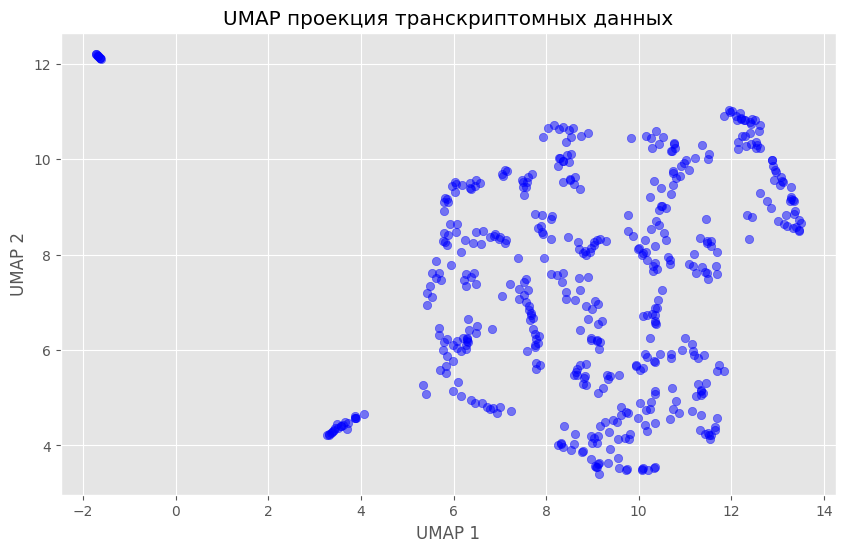

In [59]:
# 1. Снижение размерности с помощью UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_scaled)

# Визуализация UMAP
plt.figure(figsize=(10, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c='blue', alpha=0.5)
plt.title('UMAP проекция транскриптомных данных')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
if not os.path.exists('plots'):
    os.makedirs('plots')
plt.savefig('plots/umap_projection.png')
plt.show()

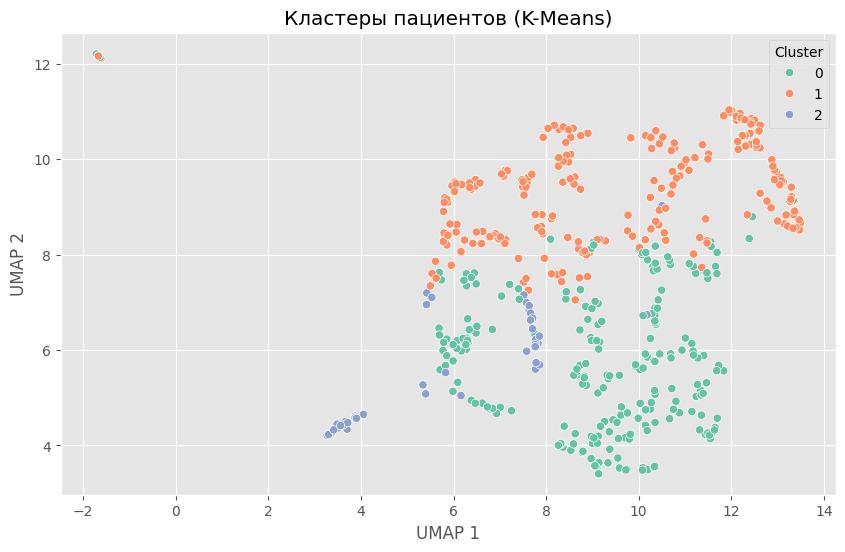

In [60]:
# 2. Кластеризация с помощью K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
df['Cluster'] = clusters

# Визуализация кластеров
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=df['Cluster'], palette='Set2')
plt.title('Кластеры пациентов (K-Means)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.savefig('plots/kmeans_clusters.png')
plt.show()

In [61]:
# 3. Выбор признаков с помощью Random Forest
# Используем Cluster как целевую переменную (замените на 'overall_survival', если доступно)
y = df['Cluster']
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Обучение Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [63]:
# Оценка модели
y_pred = rf.predict(X_test)
print("\n=== Отчет по классификации ===")
print(classification_report(y_test, y_pred))

# Важность признаков
feature_importance = pd.DataFrame({'Feature': feature_cols, 'Importance': rf.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False).head(10)


=== Отчет по классификации ===
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        48
           1       0.91      1.00      0.95        42
           2       0.73      0.80      0.76        10

    accuracy                           0.93       100
   macro avg       0.88      0.90      0.89       100
weighted avg       0.94      0.93      0.93       100



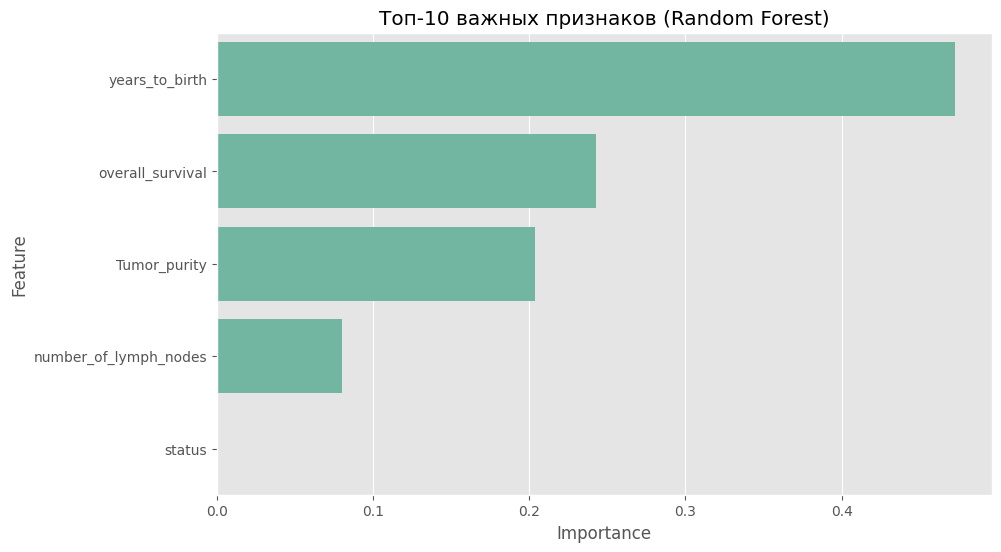

Обработанный датасет с кластерами сохранён в 'processed_clinical_with_clusters.csv'


In [64]:
# Визуализация важности признаков
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Топ-10 важных признаков (Random Forest)')
plt.savefig('plots/feature_importance.png')
plt.show()

# 6. Сохранение обработанного датасета
df.to_csv('processed_clinical_with_clusters.csv', index=False)
print("Обработанный датасет с кластерами сохранён в 'processed_clinical_with_clusters.csv'")